# Plotting PyPSA results

### Jupyter scripts need to be improved


In [31]:
###### algunas cosas cambian si pongo como comentarios el import de geoviews y hvplot

import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
#import geoviews as gv
#import hvplot.pandas 
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

import sys

sys.path.append("../")  # to import helpers
from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-africa")

max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

This is the repository path:  C:\Users\Lenovo\Desktop\pypsa-africa
Had to go 0 folder(s) up.


In [32]:
# utility function for nice plotting


def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

# Load all networks

In [33]:
# add_electricity_network = os.getcwd() + '/networks/elec.nc'
# clustered_network = os.getcwd() + '/networks/elec_s_20.nc'
solved_network = os.getcwd() + "/results/networks/elec_s_20_ec_lcopt_Co2L-3H.nc"

# n_add_el = pypsa.Network(add_electricity_network)
# n_cluster = pypsa.Network(clustered_network)
n_solve = pypsa.Network(solved_network)

INFO:pypsa.io:Imported network elec_s_20_ec_lcopt_Co2L-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


# Solved network

In [34]:
n = n_solve

In [35]:
n.global_constraints

,sense,constant,mu,type,investment_period,carrier_attribute
GlobalConstraint,,,,,,
CO2Limit,<=,77500000.0,1.750914e-09,primary_energy,NaN,co2_emissions


In [36]:
################# to be defined

# EURO/MWh
n.objective / n.loads_t.p.sum().sum()

62.61919869784461

### Spatial temporal resolution

(<matplotlib.collections.PatchCollection at 0x15a391a8820>,
 <matplotlib.collections.LineCollection at 0x15a391843d0>)

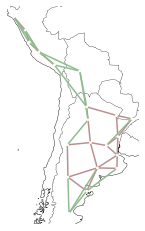

In [37]:
##### augmented lines in green (can be disabled)

n.plot()

In [8]:
# temporal resolution - timesteps
len(n.snapshots)

2920

### Overview components

In [9]:
for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name, len(c.df)))

Component 'Bus' has 60 entries
Component 'Carrier' has 14 entries
Component 'GlobalConstraint' has 1 entries
Component 'Line' has 23 entries
Component 'LineType' has 32 entries
Component 'TransformerType' has 14 entries
Component 'Link' has 95 entries
Component 'Load' has 20 entries
Component 'Generator' has 117 entries
Component 'StorageUnit' has 12 entries
Component 'Store' has 40 entries


### Energy balance

In [10]:
##### que es stores_t??? losses?

n.stores_t.p.sum()

Store
AR 0 H2          3.469447e-18
AR 1 H2          0.000000e+00
AR 10 H2         6.938894e-18
AR 11 H2         0.000000e+00
AR 12 H2         0.000000e+00
AR 13 H2        -1.040834e-17
AR 2 H2          2.428613e-17
AR 3 H2          0.000000e+00
AR 4 H2         -3.469447e-18
AR 5 H2          0.000000e+00
AR 6 H2          0.000000e+00
AR 7 H2          0.000000e+00
AR 8 H2          0.000000e+00
AR 9 H2          0.000000e+00
BO 0 H2         -3.469447e-17
PE 0 H2          0.000000e+00
PE 1 H2          0.000000e+00
PE 2 H2          0.000000e+00
PE 3 H2          0.000000e+00
PE 4 H2          0.000000e+00
AR 0 battery    -1.040834e-17
AR 1 battery    -8.673617e-19
AR 10 battery   -9.974660e-18
AR 11 battery   -1.474515e-17
AR 12 battery   -2.081668e-17
AR 13 battery   -1.127570e-17
AR 2 battery    -2.255141e-17
AR 3 battery     3.469447e-18
AR 4 battery    -2.341877e-17
AR 5 battery     4.683753e-17
AR 6 battery     4.770490e-18
AR 7 battery    -2.949030e-17
AR 8 battery    -8.673617e-18
AR 9

In [11]:
# Difference between total load and generation
# losses = n.stores_t
n.generators_t.p.sum().sum() - n.loads_t.p.sum().sum()  # - substract storage losses


n.generators


,p_nom_max,weight,p_nom,capital_cost,bus,efficiency,marginal_cost,carrier,p_nom_extendable,control,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,type,p_nom_min,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AR 0 CCGT,NaN,0.000000,4.248700e+02,0.000000,AR 0,0.500,47.209584,CCGT,False,Slack,4.248700e+02,1.000,0,0,0,1,0,,0.0,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
AR 0 oil,NaN,0.000000,4.302508e+02,0.000000,AR 0,0.393,130.237035,oil,False,,4.302508e+02,1.000,0,0,0,1,0,,0.0,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
AR 0 onwind,2.036501e+05,68094.283227,0.000000e+00,109295.569252,AR 0,1.000,0.024205,onwind,True,,1.012345e+03,1.000,0,0,0,1,0,,0.0,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
AR 0 solar,1.280590e+05,20104.114745,0.000000e+00,55064.071419,AR 0,1.000,0.019700,solar,True,,4.827111e-02,1.000,0,0,0,1,0,,0.0,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
AR 1 CCGT,inf,0.000000,1.730000e+01,0.000000,AR 1,0.500,47.210010,CCGT,False,,1.730000e+01,1.000,0,0,0,1,0,,0.0,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PE 0 load,inf,NaN,1.000000e+09,0.000000,PE 0,1.000,8000.010271,load,False,PQ,1.000000e+09,0.001,0,0,0,1,0,,0.0,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
PE 1 load,inf,NaN,1.000000e+09,0.000000,PE 1,1.000,8000.010756,load,False,PQ,1.000000e+09,0.001,0,0,0,1,0,,0.0,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
PE 2 load,inf,NaN,1.000000e+09,0.000000,PE 2,1.000,8000.010877,load,False,PQ,1.000000e+09,0.001,0,0,0,1,0,,0.0,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0


### Total installed generator capacity

In [12]:
gen_cap = n.generators.groupby(["carrier"]).sum()
gen_cap

,p_nom_max,weight,p_nom,capital_cost,efficiency,marginal_cost,p_nom_extendable,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,p_nom_min,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
carrier,,,,,,,,,,,,,,,,,,,,,,,,,,,
CCGT,NaN,0.000000e+00,1.046207e+04,0.000000e+00,8.000,755.361360,0,1.046207e+04,16.00,0,0,0,16,0,0.0,0.0,16.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,16.0,16.0
OCGT,NaN,0.000000e+00,7.127537e+03,0.000000e+00,3.120,467.155068,0,7.127537e+03,8.00,0,0,0,8,0,0.0,0.0,8.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,8.0,8.0
coal,NaN,0.000000e+00,2.359200e+03,0.000000e+00,2.320,120.566860,0,2.359200e+03,5.00,0,0,0,5,0,0.0,0.0,5.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,5.0,5.0
load,NaN,0.000000e+00,2.000000e+10,0.000000e+00,20.000,160000.203826,0,2.000000e+10,0.02,0,0,0,20,0,0.0,0.0,20.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,20.0,20.0
oil,NaN,0.000000e+00,1.244730e+04,0.000000e+00,5.895,1953.549068,0,1.244730e+04,15.00,0,0,0,15,0,0.0,0.0,15.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,15.0,15.0
onwind,1.015664e+07,1.976444e+06,0.000000e+00,2.185911e+06,20.000,0.496760,20,1.328645e+04,20.00,0,0,0,20,0,0.0,0.0,20.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,20.0,20.0
ror,NaN,6.145570e+03,6.145570e+03,3.522229e+06,11.700,0.129543,0,6.145570e+03,13.00,0,0,0,13,0,0.0,0.0,13.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,13.0,13.0
solar,5.027147e+06,8.764364e+05,0.000000e+00,1.101281e+06,20.000,0.396020,20,1.915653e+04,20.00,0,0,0,20,0,0.0,0.0,20.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,20.0,20.0


In [13]:
n.stores_t.p

Store,AR 0 H2,AR 1 H2,AR 10 H2,AR 11 H2,AR 12 H2,AR 13 H2,AR 2 H2,AR 3 H2,AR 4 H2,AR 5 H2,AR 6 H2,AR 7 H2,AR 8 H2,AR 9 H2,BO 0 H2,PE 0 H2,PE 1 H2,PE 2 H2,PE 3 H2,PE 4 H2,AR 0 battery,AR 1 battery,AR 10 battery,AR 11 battery,AR 12 battery,AR 13 battery,AR 2 battery,AR 3 battery,AR 4 battery,AR 5 battery,AR 6 battery,AR 7 battery,AR 8 battery,AR 9 battery,BO 0 battery,PE 0 battery,PE 1 battery,PE 2 battery,PE 3 battery,PE 4 battery
snapshot,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.000266,0.000284,0.004087,0.000162,0.001105,0.001925,0.001864,0.000133,0.000489,0.000158,0.000016,0.001065,1.839150e-04,0.000554,0.000506,0.000631,0.000504,0.000614,0.000518,0.000500,0.000231,0.001168,0.002385,0.000505,0.003872,0.002476,0.002511,0.000176,0.000710,0.000232,-1.727603e-04,0.003761,0.000651,0.001868,0.006590,0.001459,0.001240,0.001577,0.001284,0.001249
2013-01-01 03:00:00,0.000221,-0.000070,0.004173,0.000033,0.000070,0.001796,0.001757,0.000086,0.000483,0.000109,0.000051,0.000127,-6.351785e-05,0.000514,-0.000649,0.000641,0.000513,0.000629,0.000528,0.000513,-0.000036,-0.000444,0.000725,-0.000105,-0.001228,0.000412,0.000491,-0.000032,0.000166,-0.000039,3.643066e-05,-0.001176,-0.000413,0.000353,-0.006377,0.002069,0.001831,0.002197,0.001866,0.001835
2013-01-01 06:00:00,0.000259,-0.000048,0.004118,0.000059,0.000081,0.001794,0.001755,0.000124,0.000505,0.000152,0.000083,0.000132,-3.311121e-05,0.000554,-0.000629,-0.000374,-0.000487,-0.000381,-0.000470,-0.000476,0.000141,0.000001,0.000433,0.000111,-0.000281,0.000268,0.000306,0.000141,0.000199,0.000148,1.309979e-04,-0.000291,-0.000005,0.000264,-0.005499,-0.003925,-0.003492,-0.003903,-0.003474,-0.003488
2013-01-01 09:00:00,0.000259,-0.000038,0.003978,0.000048,0.000069,0.001750,0.001706,0.000126,0.000496,0.000154,0.000082,0.000117,-4.753778e-06,0.000552,0.000501,0.000619,0.000495,0.000610,0.000508,0.000494,0.000035,0.000047,0.000134,0.000064,-0.000143,0.000100,0.000090,0.000083,0.000071,0.000079,6.718165e-05,-0.000169,0.000154,0.000083,0.010935,0.004780,0.004212,0.004571,0.004254,0.004191
2013-01-01 12:00:00,0.000241,-0.000082,0.004040,0.000018,0.000029,0.001729,0.001667,0.000096,0.000457,0.000124,0.000045,0.000082,-4.830152e-05,0.000529,-0.000670,-0.000485,-0.000577,-0.000380,-0.000588,-0.000586,-0.000211,-0.000159,0.000093,-0.000195,-0.000288,-0.000186,-0.000193,-0.000177,-0.000221,-0.000207,-2.107167e-04,-0.000326,-0.000169,-0.000196,-0.004317,0.000825,0.000894,0.001167,0.000885,0.000879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,0.000213,-0.000034,0.001670,0.000038,0.000118,0.001968,0.001944,0.000109,0.000553,0.000118,0.000097,0.000173,1.515928e-05,0.000510,0.000493,0.000641,0.000512,0.000613,0.000528,0.000494,0.000187,0.000170,0.000420,0.000164,-0.000019,0.000113,0.000102,0.000177,-0.000022,0.000173,1.095601e-04,-0.000034,0.000194,0.000143,0.011539,0.004505,0.003954,0.004466,0.004011,0.003992
2013-12-31 12:00:00,0.000158,-0.000079,0.001611,-0.000023,0.000066,0.001894,0.001858,0.000045,0.000509,0.000057,0.000058,0.000121,-3.766628e-05,0.000460,-0.000741,-0.000466,-0.000579,-0.000453,-0.000564,-0.000602,-0.000016,0.000137,-0.000081,-0.000015,-0.000208,-0.000027,-0.000036,-0.000029,-0.000147,-0.000016,-9.891373e-07,-0.000244,0.000096,0.000046,-0.004505,-0.002275,-0.001960,-0.002012,-0.001958,-0.001933
2013-12-31 15:00:00,0.000131,-0.000133,0.001584,-0.000053,0.000115,0.001783,0.001762,0.000007,0.000512,0.000019,0.000052,0.000183,-9.141241e-05,0.000432,-0.000556,-0.000317,-0.000443,-0.000364,-0.000444,-0.000465,-0.000125,-0.000547,0.000780,-0.000296,0.000374,0.000333,0.000377,-0.000254,0.000538,-0.000177,1.120091e-05,0.000531,-0.000412,0.000270,-0.002650,-0.000678,-0.000627,-0.000782,-0.000679,-0.000635


<AxesSubplot:xlabel='snapshot'>

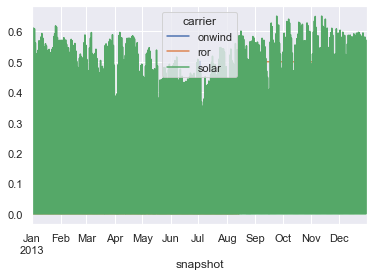

In [14]:
n.generators_t.p_max_pu.groupby(n.generators.carrier, axis=1).mean().plot()

In [15]:
# If 0, all renewable capacity potential is used
n.generators.p_nom_max.sum() - n.generators.p_nom_opt.sum()

inf

In [16]:
n.loads_t.p.sum().sum()

93050599.29425743

In [17]:
n.generators_t.p.sum().sum()

67682545.15837397

In [18]:
#### pq la multiplicacion?

n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom.sum() * 0.0000003

bus   carrier
AR 0  CCGT         0.000127
      load       300.000000
      oil          0.000129
      onwind       0.000000
      solar        0.000000
                    ...    
PE 4  OCGT         0.000048
      load       300.000000
      onwind       0.000000
      ror          0.000109
      solar        0.000000
Name: p_nom, Length: 117, dtype: float64

AssertionError: Colors not defined for all elements in the second MultiIndex level of bus_sizes, please make sure that all the elements are included in bus_colors or in n.carriers.color

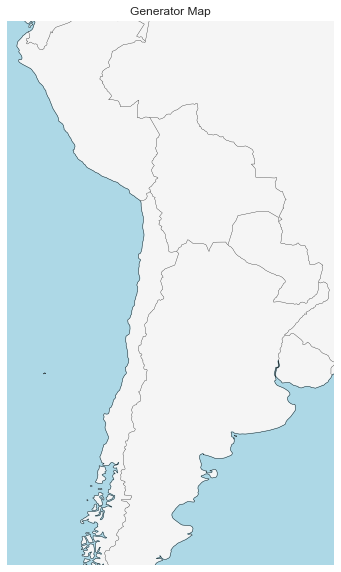

In [19]:
######################################################## se importaron librerias nuevamente por los errores en celdas anteriores
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
########################################################

fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

# loading = (n3.lines_t.p0.abs().mean().sort_index() / (n3.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom_opt.sum()
    ),
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="Generator Map",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off");

### Demand

In [20]:
type(n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum())

pandas.core.series.Series

<AxesSubplot:xlabel='snapshot'>

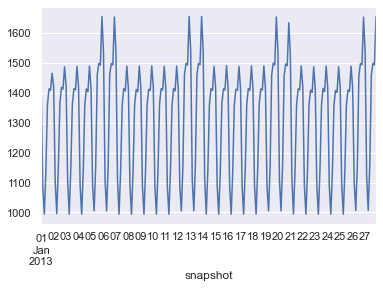

In [21]:
n.loads_t.p_set.loc["2013-01-01":"2013-01-27","BO 0"].plot()

In [22]:
type(n.loads_t.p_set.sum())

pandas.core.series.Series

In [23]:
a = n.loads_t.p_set.sum().rename("load").rename_axis("bus")
a.rename("load", inplace=True)
a.rename_axis("bus", inplace=True)
a

bus
AR 0     2.856281e+06
AR 1     3.324431e+06
AR 10    2.323003e+05
AR 11    4.284589e+06
AR 12    3.860456e+06
AR 13    7.730291e+05
AR 2     2.544510e+06
AR 3     7.209735e+06
AR 4     3.981238e+06
AR 5     2.021261e+07
AR 6     7.164671e+06
AR 7     3.143364e+06
AR 8     2.002765e+06
AR 9     5.511209e+06
BO 0     3.779364e+06
PE 0     4.449220e+06
PE 1     3.693503e+06
PE 2     3.901972e+06
PE 3     5.362340e+06
PE 4     4.763008e+06
Name: load, dtype: float64

In [24]:
n.loads_t.p_set.sum().rename("load").rename_axis("bus")

bus
AR 0     2.856281e+06
AR 1     3.324431e+06
AR 10    2.323003e+05
AR 11    4.284589e+06
AR 12    3.860456e+06
AR 13    7.730291e+05
AR 2     2.544510e+06
AR 3     7.209735e+06
AR 4     3.981238e+06
AR 5     2.021261e+07
AR 6     7.164671e+06
AR 7     3.143364e+06
AR 8     2.002765e+06
AR 9     5.511209e+06
BO 0     3.779364e+06
PE 0     4.449220e+06
PE 1     3.693503e+06
PE 2     3.901972e+06
PE 3     5.362340e+06
PE 4     4.763008e+06
Name: load, dtype: float64

In [25]:
n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum()

###### potencia maxima?
n.generators.iloc[:, :].groupby(["bus"]).p_max_pu.sum()

bus
AR 0     5.0
AR 1     5.0
AR 10    6.0
AR 11    5.0
AR 12    7.0
AR 13    7.0
AR 2     7.0
AR 3     6.0
AR 4     6.0
AR 5     7.0
AR 6     6.0
AR 7     8.0
AR 8     6.0
AR 9     7.0
BO 0     3.0
PE 0     4.0
PE 1     4.0
PE 2     7.0
PE 3     6.0
PE 4     5.0
Name: p_max_pu, dtype: float64

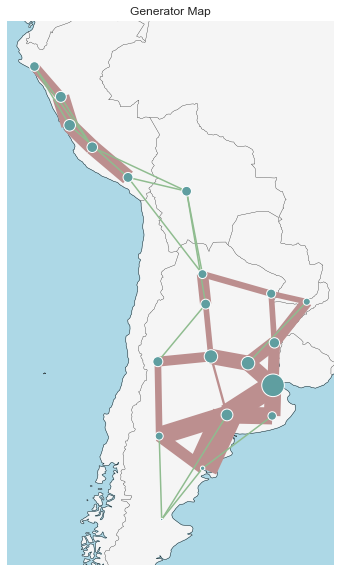

In [26]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

# loading = (n3.lines_t.p0.abs().mean().sort_index() / (n3.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        n.loads_t.p_set.sum().rename("load").rename_axis("bus")
    ),  # n.loads_t.p_set.sum().rename("load").rename_axis("bus")*.0000003,
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="Generator Map",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off");

In [27]:
# backup
gen_serie = n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom_opt.sum()
load_serie = n.loads_t.p_set.sum().rename("load").rename_axis("bus")

load_serie = pd.Series(
    load_serie.values,
    index=pd.MultiIndex.from_tuples([(id, "AC load") for id in load_serie.index]),
)

tot_serie = pd.concat([gen_serie, load_serie])  # .groupby(['bus', 'carrier']).sum()

pd.concat([gen_serie, load_serie])

bus   carrier
AR 0  CCGT       4.248700e+02
      load       1.000000e+09
      oil        4.302508e+02
      onwind     1.012345e+03
      solar      4.827111e-02
                     ...     
PE 0  AC load    4.449220e+06
PE 1  AC load    3.693503e+06
PE 2  AC load    3.901972e+06
PE 3  AC load    5.362340e+06
PE 4  AC load    4.763008e+06
Length: 137, dtype: float64

### Plot of Average Marginal Price

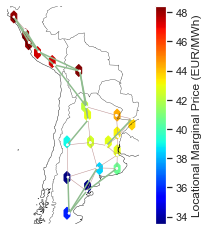

In [28]:
now = n.snapshots[4]  ##one specific time

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(6, 4)

n.plot(ax=ax, line_widths=pd.Series(0.5, n.lines.index))
plt.hexbin(
    n.buses.x,
    n.buses.y,
    gridsize=20,
    # C=n.buses_t.marginal_price.loc[now], #at one time (previous set up by scigrid)
    C=n.buses_t.marginal_price.sum()
    / len(n.snapshots[:]),  # Marginal price averaged over the whole year (My version)
    # - shows in which regions electricity will be cheap and where el. intensive companies should be placed.
    cmap=plt.cm.jet,
)

# for some reason the colorbar only works with graphs plt.plot
# and must be attached plt.colorbar

cb = plt.colorbar()
cb.set_label("Locational Marginal Price (EUR/MWh)")

### Storage

<AxesSubplot:xlabel='snapshot'>

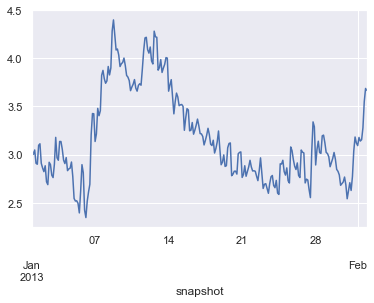

In [29]:
n.stores_t.e.loc["2013-01-01":"2013-02-01"].sum(axis=1).plot()

In [30]:
n.links.iloc[:].groupby(["carrier"]).p_nom_opt.sum()

carrier
DC                    2064.563923
H2 electrolysis          0.123614
H2 fuel cell             0.142712
battery charger          0.218003
battery discharger       0.242225
Name: p_nom_opt, dtype: float64